# CNN Baseline - iWildCam 2019

Breakdown of this notebook:
1. **Loading the 32x32 dataset**: Load the data generated in *Reducing Image Sizes to 32x32*.
2. **Create Callback for F1 Score**: F1-macro score is the official metric of the competition. We create a callback to keep track of that value as we train the model.
3. **Creating and Training the Model**: Create a simple model (taken from the official Keras tutorial) and train it.
4. **Evaluation**: Display the plots from the training history.
5. **Submission**: Run predictions with `model.predict`, and create submission csv file.

### References
* [cifar10_cnn_keras.py](https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py): Heavily inspired from this tutorial created by the Keras team. The architecture and training process is directly taken from them.
* [Keras CNN Starter - PetFinder](https://www.kaggle.com/xhlulu/keras-cnn-starter-petfinder/): History plot and submission are inspired by this kernel
* [Reducing Image Sizes to 32x32](https://www.kaggle.com/xhlulu/reducing-image-sizes-to-32x32): Image data (`X_train`, `X_test`) come from the output of this kernel.
* [How to compute f1 score for each epoch in Keras](https://medium.com/@thongonary/how-to-compute-f1-score-for-each-epoch-in-keras-a1acd17715a2): Needed to compute the F1 Score after each epoch.

In [1]:
import os
import json

import numpy as np
import pandas as pd
import keras
from keras.callbacks import Callback
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

In [2]:
os.listdir('../input')

['fft-test-image', 'reducing-image-sizes-to-32x32', 'iwildcam-2019-fgvc6']

# 0. FFT Setup

In [3]:
import cv2
import numpy as np
import tensorflow as tf
# from tensorflow import signal
import numpy.fft as fft
import matplotlib as mpl

import matplotlib.pyplot as plt

%matplotlib inline
mpl.rcParams['figure.figsize'] = (12, 5)
mpl.rcParams['image.cmap'] = "gray"

In [4]:

def image_n_fft(real_img, plot=False):
    if plot==True:
#         real_img = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
        Img = fft.fft2(real_img)
        mag = np.abs(fft.fftshift(Img))
        plt.subplot(1,2,1)
        plt.imshow(real_img); plt.axis('off');
        plt.subplot(1,2,2)
        plt.imshow(20*np.log10(mag**2 + 1)); plt.axis('off'); plt.title('Power (dB)');
    return fft.fft2(real_img)

In [5]:
def image_n_fft_ranged(real_img, range_low, range_high, plot=False):
    x, y = np.meshgrid(range(real_img.shape[0]), range(real_img.shape[1]))
    r = np.sqrt((x - x.mean())**2 + (y - y.mean())**2)
        
    if plot==True:
#         real_img = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
#         print(type(real_img))
        Img = fft.fft2(real_img)

        _Img = np.where((r > range_low) & (r < range_high), fft.fftshift(Img), 0)
        mag = np.abs(_Img)
        plt.subplot(1,2,1)
        plt.imshow(fft.ifft2(fft.fftshift(_Img)).real); plt.axis('off');
        plt.subplot(1,2,2)
        plt.imshow(20*np.log10(mag**2 + 1)); plt.axis('off'); plt.title('Power (dB)');
        print(type(fft.ifft2(fft.fftshift(_Img)).real))
        print(fft.ifft2(fft.fftshift(_Img)).real)
    
    return np.where((r > range_low) & (r < range_high), fft.fftshift(fft.fft2(real_img)), 0)

array([[ 6.32583950e+07      +0.j        ,
        -3.82785724e+06-1243563.69750258j,
        -2.19446775e+06+2484085.27256107j, ...,
        -1.87848537e+05 +997766.70685262j,
        -2.19446775e+06-2484085.27256107j,
        -3.82785724e+06+1243563.69750258j],
       [-7.08443323e+06-2880064.69855541j,
         8.68545260e+05 +277713.1103071j ,
         2.55913946e+06-2426482.9691034j , ...,
         7.02057946e+04  +22034.06267725j,
         2.38602999e+06 +404183.72010101j,
        -5.11195315e+06 -744233.31960675j],
       [ 8.09115887e+05-1912039.26633563j,
        -5.26427476e+05 -772299.3815135j ,
        -7.08210545e+04 +815050.56381426j, ...,
         7.10894092e+05-1254758.55562614j,
        -3.57206446e+04 +317388.74406846j,
        -4.08389229e+05 +934441.38538909j],
       ...,
       [ 2.02554094e+05 -932594.047056j  ,
         5.51799327e+05+1328428.54044855j,
        -3.61180400e+05 -173652.52259134j, ...,
         8.32755943e+05 -558058.91547562j,
        -6.36016353

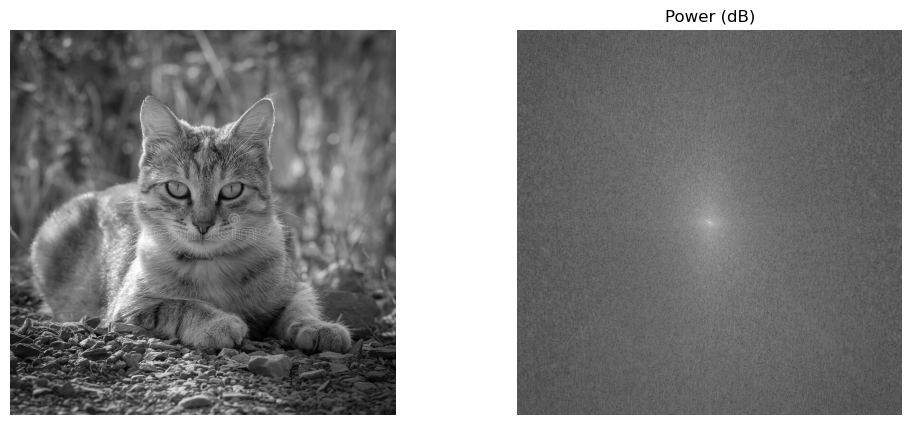

In [6]:
real_img = cv2.imread('../input/fft-test-image/test.jpg', cv2.IMREAD_GRAYSCALE)
image_n_fft(real_img, True)

<class 'numpy.ndarray'>
[[ 5.63039893  6.53533917  7.2250857  ...  1.82478031  3.24970565
   4.52749391]
 [ 6.94314903  7.53091353  7.88906181 ...  3.96403279  5.1374887
   6.1388261 ]
 [ 8.16628465  8.43040461  8.45091161 ...  6.03679565  6.9503338
   7.66755191]
 ...
 [ 1.5152986   3.29031292  4.89513131 ... -4.51340522 -2.42179585
  -0.40004172]
 [ 2.88013764  4.38272586  5.69991125 ... -2.4613109  -0.57385268
   1.21783863]
 [ 4.26384131  5.47511069  6.48595113 ... -0.33304231  1.33108375
   2.87360219]]


array([[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       ...,
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]])

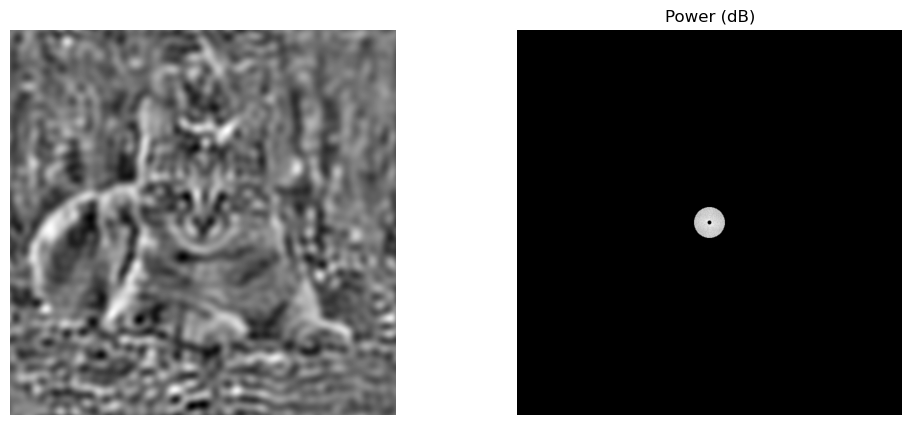

In [7]:
image_n_fft_ranged(real_img, 4 ,32, True)


## 1. Loading the 32x32 dataset

In [8]:
# The data, split between train and test sets:
x_train = np.load('../input/reducing-image-sizes-to-32x32/X_train.npy')
x_test = np.load('../input/reducing-image-sizes-to-32x32/X_test.npy')
y_train = np.load('../input/reducing-image-sizes-to-32x32/y_train.npy')

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (196299, 32, 32, 3)
196299 train samples
153730 test samples


In [9]:
# Convert the images to float and scale it to a range of 0 to 1
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.
x_test /= 255.

In [10]:
i = 0
for pic in x_train:
#     pic = cv2.cvtColor(pic, cv2.COLOR_BGR2GRAY)

#     print(pic.shape)
    if i == 0:
        i+=1
        print(cv2.cvtColor(pic, cv2.COLOR_BGR2GRAY))
    pic = image_n_fft_ranged(cv2.cvtColor(pic, cv2.COLOR_BGR2GRAY), 0, 8)
    

for pic in x_test:
    pic = image_n_fft_ranged(cv2.cvtColor(pic, cv2.COLOR_BGR2GRAY), 0, 8)
    
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

[[0.01176471 0.00784314 0.01568628 ... 0.03529412 0.01568628 0.        ]
 [0.19607845 0.21960784 0.1882353  ... 0.16078432 0.14117648 0.20784314]
 [0.12941177 0.18431373 0.18039216 ... 0.16078432 0.15686275 0.14509805]
 ...
 [0.3529412  0.36078432 0.2627451  ... 0.1764706  0.16470589 0.14509805]
 [0.36862746 0.34901962 0.26666668 ... 0.14901961 0.14117648 0.13725491]
 [0.3764706  0.34117648 0.2509804  ... 0.15194118 0.1234902  0.12823921]]
x_train shape: (196299, 32, 32, 3)
196299 train samples
153730 test samples


## 2. Create Callback for F1 score

In [11]:
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []
        

    def on_epoch_end(self, epoch, logs={}):
        
#         print(self.validation_data[:2])
#         X_val, y_val = self.validation_data[:2]
#         X_val, y_val = x_train, y_train
        y_pred = self.model.predict(x_train[:1000])

        y_pred_cat = keras.utils.to_categorical(
            y_pred.argmax(axis=1),
            num_classes=num_classes
        )

        _val_f1 = f1_score(y_train[:1000], y_pred_cat, average='macro')
        _val_recall = recall_score(y_train[:1000], y_pred_cat, average='macro')
        _val_precision = precision_score(y_train[:1000], y_pred_cat, average='macro')

        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)

        print((f"val_f1: {_val_f1:.4f}"
               f" — val_precision: {_val_precision:.4f}"
               f" — val_recall: {_val_recall:.4f}"))

        return

## 3. Creating and Training the Model

In [12]:
batch_size = 64
num_classes = 14
epochs = 30
val_split = 0.1
save_dir = os.path.join(os.getcwd(), 'models')
print(save_dir)
model_name = 'keras_cnn_model.h5'

/kaggle/working/models


In [13]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 32)        0         
                                                        

In [14]:
# print(x_train[0])
# os.environ['TF_DISABLE_NXPLANNER'] = '1'

In [15]:
%%time
# x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

f1_metrics = Metrics()

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
# print("XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX")
hist = model.fit(
    x_train, 
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[f1_metrics],
    validation_split=val_split,
#     validation_data=(x_val, y_val),
    shuffle=True
)

Epoch 1/30


2023-04-28 00:28:51.306407: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


32/32 [==============================] - 0s 3ms/step - loss: 0.7068 - accuracy: 0.
val_f1: 0.4825 — val_precision: 0.6138 — val_recall: 0.4550
2761/2761 [==============================] - 28s 7ms/step - loss: 0.7068 - accuracy: 0.7821 - val_loss: 0.4951 - val_accuracy: 0.8419
Epoch 2/30
  28/2761 [..............................] - ETA: 16s - loss: 0.5201 - accuracy: 0.8320

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 0s 2ms/step - loss: 0.5125 - accuracy: 0.
val_f1: 0.5627 — val_precision: 0.6424 — val_recall: 0.5473
2761/2761 [==============================] - 18s 6ms/step - loss: 0.5124 - accuracy: 0.8341 - val_loss: 0.4046 - val_accuracy: 0.8642
Epoch 3/30
  28/2761 [..............................] - ETA: 16s - loss: 0.4297 - accuracy: 0.8549

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 0s 2ms/step - loss: 0.4519 - accuracy: 0.
val_f1: 0.6386 — val_precision: 0.6862 — val_recall: 0.6240
2761/2761 [==============================] - 18s 7ms/step - loss: 0.4519 - accuracy: 0.8518 - val_loss: 0.3696 - val_accuracy: 0.8762
Epoch 4/30
  28/2761 [..............................] - ETA: 16s - loss: 0.4011 - accuracy: 0.8683

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 0s 2ms/step - loss: 0.4161 - accuracy: 0.
val_f1: 0.6856 — val_precision: 0.7429 — val_recall: 0.6536
2761/2761 [==============================] - 18s 7ms/step - loss: 0.4160 - accuracy: 0.8628 - val_loss: 0.3397 - val_accuracy: 0.8873
Epoch 5/30
  28/2761 [..............................] - ETA: 16s - loss: 0.4002 - accuracy: 0.8544

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 0s 2ms/step - loss: 0.3916 - accuracy: 0.
val_f1: 0.7042 — val_precision: 0.7173 — val_recall: 0.7003
2761/2761 [==============================] - 18s 7ms/step - loss: 0.3916 - accuracy: 0.8691 - val_loss: 0.3186 - val_accuracy: 0.8942
Epoch 6/30
  28/2761 [..............................] - ETA: 16s - loss: 0.3954 - accuracy: 0.8744

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 0s 3ms/step - loss: 0.3700 - accuracy: 0.
val_f1: 0.7108 — val_precision: 0.7430 — val_recall: 0.6915
2761/2761 [==============================] - 18s 6ms/step - loss: 0.3702 - accuracy: 0.8767 - val_loss: 0.3073 - val_accuracy: 0.8979
Epoch 7/30
  20/2761 [..............................] - ETA: 23s - loss: 0.3807 - accuracy: 0.8766

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 0s 2ms/step - loss: 0.3537 - accuracy: 0.
val_f1: 0.7643 — val_precision: 0.7825 — val_recall: 0.7529
2761/2761 [==============================] - 18s 6ms/step - loss: 0.3537 - accuracy: 0.8813 - val_loss: 0.2908 - val_accuracy: 0.9015
Epoch 8/30
  28/2761 [..............................] - ETA: 16s - loss: 0.3205 - accuracy: 0.8873

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 0s 2ms/step - loss: 0.3412 - accuracy: 0.
val_f1: 0.7466 — val_precision: 0.7608 — val_recall: 0.7419
2761/2761 [==============================] - 18s 6ms/step - loss: 0.3412 - accuracy: 0.8841 - val_loss: 0.2811 - val_accuracy: 0.9065
Epoch 9/30
  28/2761 [..............................] - ETA: 16s - loss: 0.3329 - accuracy: 0.8811

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 0s 2ms/step - loss: 0.3310 - accuracy: 0.
val_f1: 0.7634 — val_precision: 0.7896 — val_recall: 0.7475
2761/2761 [==============================] - 18s 6ms/step - loss: 0.3310 - accuracy: 0.8878 - val_loss: 0.2796 - val_accuracy: 0.9053
Epoch 10/30
  27/2761 [..............................] - ETA: 16s - loss: 0.2690 - accuracy: 0.9057

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 0s 2ms/step - loss: 0.3218 - accuracy: 0.
val_f1: 0.7530 — val_precision: 0.7749 — val_recall: 0.7399
2761/2761 [==============================] - 18s 7ms/step - loss: 0.3218 - accuracy: 0.8905 - val_loss: 0.2790 - val_accuracy: 0.9063
Epoch 11/30
  28/2761 [..............................] - ETA: 16s - loss: 0.3473 - accuracy: 0.8862

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 0s 2ms/step - loss: 0.3132 - accuracy: 0.
val_f1: 0.7739 — val_precision: 0.7840 — val_recall: 0.7675
2761/2761 [==============================] - 18s 6ms/step - loss: 0.3131 - accuracy: 0.8926 - val_loss: 0.2628 - val_accuracy: 0.9141
Epoch 12/30
  28/2761 [..............................] - ETA: 16s - loss: 0.2930 - accuracy: 0.9018

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 0s 2ms/step - loss: 0.3057 - accuracy: 0.
val_f1: 0.7461 — val_precision: 0.7638 — val_recall: 0.7337
2761/2761 [==============================] - 18s 6ms/step - loss: 0.3056 - accuracy: 0.8957 - val_loss: 0.2623 - val_accuracy: 0.9124
Epoch 13/30
  28/2761 [..............................] - ETA: 16s - loss: 0.2544 - accuracy: 0.9113

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 0s 2ms/step - loss: 0.3010 - accuracy: 0.
val_f1: 0.8035 — val_precision: 0.8121 — val_recall: 0.8005
2761/2761 [==============================] - 18s 7ms/step - loss: 0.3009 - accuracy: 0.8973 - val_loss: 0.2580 - val_accuracy: 0.9163
Epoch 14/30
  28/2761 [..............................] - ETA: 16s - loss: 0.3364 - accuracy: 0.8912

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 0s 2ms/step - loss: 0.2975 - accuracy: 0.
val_f1: 0.7819 — val_precision: 0.7943 — val_recall: 0.7751
2761/2761 [==============================] - 18s 6ms/step - loss: 0.2975 - accuracy: 0.8987 - val_loss: 0.2547 - val_accuracy: 0.9160
Epoch 15/30
  28/2761 [..............................] - ETA: 16s - loss: 0.2945 - accuracy: 0.8945

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 0s 2ms/step - loss: 0.2912 - accuracy: 0.
val_f1: 0.7933 — val_precision: 0.8059 — val_recall: 0.7849
2761/2761 [==============================] - 18s 7ms/step - loss: 0.2912 - accuracy: 0.9005 - val_loss: 0.2450 - val_accuracy: 0.9194
Epoch 16/30
  28/2761 [..............................] - ETA: 16s - loss: 0.3042 - accuracy: 0.8962

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 0s 3ms/step - loss: 0.2862 - accuracy: 0.
val_f1: 0.7984 — val_precision: 0.8197 — val_recall: 0.7839
2761/2761 [==============================] - 18s 6ms/step - loss: 0.2862 - accuracy: 0.9012 - val_loss: 0.2436 - val_accuracy: 0.9184
Epoch 17/30
  28/2761 [..............................] - ETA: 16s - loss: 0.2747 - accuracy: 0.9107

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 0s 2ms/step - loss: 0.2814 - accuracy: 0.
val_f1: 0.8094 — val_precision: 0.8277 — val_recall: 0.7961
2761/2761 [==============================] - 18s 7ms/step - loss: 0.2814 - accuracy: 0.9033 - val_loss: 0.2368 - val_accuracy: 0.9218
Epoch 18/30
  28/2761 [..............................] - ETA: 16s - loss: 0.2528 - accuracy: 0.9129

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 0s 2ms/step - loss: 0.2780 - accuracy: 0.
val_f1: 0.7935 — val_precision: 0.8001 — val_recall: 0.7888
2761/2761 [==============================] - 18s 6ms/step - loss: 0.2780 - accuracy: 0.9044 - val_loss: 0.2355 - val_accuracy: 0.9216
Epoch 19/30
  28/2761 [..............................] - ETA: 16s - loss: 0.2584 - accuracy: 0.9135

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 0s 2ms/step - loss: 0.2755 - accuracy: 0.
val_f1: 0.7947 — val_precision: 0.8052 — val_recall: 0.7891
2761/2761 [==============================] - 18s 6ms/step - loss: 0.2755 - accuracy: 0.9051 - val_loss: 0.2358 - val_accuracy: 0.9220
Epoch 20/30
  27/2761 [..............................] - ETA: 16s - loss: 0.2381 - accuracy: 0.9091

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 0s 2ms/step - loss: 0.2721 - accuracy: 0.
val_f1: 0.7989 — val_precision: 0.8128 — val_recall: 0.7879
2761/2761 [==============================] - 18s 6ms/step - loss: 0.2721 - accuracy: 0.9064 - val_loss: 0.2300 - val_accuracy: 0.9229
Epoch 21/30
  28/2761 [..............................] - ETA: 16s - loss: 0.2771 - accuracy: 0.9023

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 0s 2ms/step - loss: 0.2686 - accuracy: 0.
val_f1: 0.8091 — val_precision: 0.8197 — val_recall: 0.8047
2761/2761 [==============================] - 18s 7ms/step - loss: 0.2686 - accuracy: 0.9073 - val_loss: 0.2325 - val_accuracy: 0.9208
Epoch 22/30
  25/2761 [..............................] - ETA: 17s - loss: 0.2755 - accuracy: 0.9031

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 0s 2ms/step - loss: 0.2649 - accuracy: 0.
val_f1: 0.7939 — val_precision: 0.7985 — val_recall: 0.7969
2761/2761 [==============================] - 18s 6ms/step - loss: 0.2650 - accuracy: 0.9091 - val_loss: 0.2308 - val_accuracy: 0.9222
Epoch 23/30
  28/2761 [..............................] - ETA: 16s - loss: 0.2654 - accuracy: 0.9090

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 0s 2ms/step - loss: 0.2631 - accuracy: 0.
val_f1: 0.8033 — val_precision: 0.8089 — val_recall: 0.8004
2761/2761 [==============================] - 18s 6ms/step - loss: 0.2633 - accuracy: 0.9080 - val_loss: 0.2276 - val_accuracy: 0.9232
Epoch 24/30
  28/2761 [..............................] - ETA: 16s - loss: 0.2631 - accuracy: 0.9079

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 0s 2ms/step - loss: 0.2614 - accuracy: 0.
val_f1: 0.8113 — val_precision: 0.8258 — val_recall: 0.8041
2761/2761 [==============================] - 18s 7ms/step - loss: 0.2614 - accuracy: 0.9091 - val_loss: 0.2313 - val_accuracy: 0.9243
Epoch 25/30
  28/2761 [..............................] - ETA: 16s - loss: 0.2714 - accuracy: 0.9057

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 0s 2ms/step - loss: 0.2572 - accuracy: 0.
val_f1: 0.8172 — val_precision: 0.8181 — val_recall: 0.8214
2761/2761 [==============================] - 18s 6ms/step - loss: 0.2572 - accuracy: 0.9111 - val_loss: 0.2275 - val_accuracy: 0.9264
Epoch 26/30
  27/2761 [..............................] - ETA: 16s - loss: 0.2501 - accuracy: 0.9103

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 0s 2ms/step - loss: 0.2557 - accuracy: 0.
val_f1: 0.8058 — val_precision: 0.8598 — val_recall: 0.7832
2761/2761 [==============================] - 18s 7ms/step - loss: 0.2557 - accuracy: 0.9116 - val_loss: 0.2226 - val_accuracy: 0.9268
Epoch 27/30
  28/2761 [..............................] - ETA: 16s - loss: 0.2649 - accuracy: 0.8984

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 0s 2ms/step - loss: 0.2551 - accuracy: 0.
val_f1: 0.8105 — val_precision: 0.8201 — val_recall: 0.8058
2761/2761 [==============================] - 18s 7ms/step - loss: 0.2551 - accuracy: 0.9117 - val_loss: 0.2225 - val_accuracy: 0.9271
Epoch 28/30
  28/2761 [..............................] - ETA: 16s - loss: 0.2390 - accuracy: 0.9191

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 0s 2ms/step - loss: 0.2526 - accuracy: 0.
val_f1: 0.8204 — val_precision: 0.8676 — val_recall: 0.8011
2761/2761 [==============================] - 18s 6ms/step - loss: 0.2525 - accuracy: 0.9125 - val_loss: 0.2218 - val_accuracy: 0.9259
Epoch 29/30
  27/2761 [..............................] - ETA: 16s - loss: 0.2388 - accuracy: 0.9213

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 0s 2ms/step - loss: 0.2492 - accuracy: 0.
val_f1: 0.8062 — val_precision: 0.8189 — val_recall: 0.7985
2761/2761 [==============================] - 18s 7ms/step - loss: 0.2492 - accuracy: 0.9128 - val_loss: 0.2199 - val_accuracy: 0.9276
Epoch 30/30
  28/2761 [..............................] - ETA: 16s - loss: 0.2510 - accuracy: 0.9118

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 0s 2ms/step - loss: 0.2495 - accuracy: 0.
val_f1: 0.8122 — val_precision: 0.8186 — val_recall: 0.8222
2761/2761 [==============================] - 18s 6ms/step - loss: 0.2493 - accuracy: 0.9141 - val_loss: 0.2303 - val_accuracy: 0.9231


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CPU times: user 9min 18s, sys: 39.9 s, total: 9min 58s
Wall time: 9min 27s


Save model and weights

In [16]:
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /kaggle/working/models/keras_cnn_model.h5 


## 4. Evaluation

KeyError: "None of [Index(['acc', 'val_acc'], dtype='object')] are in the [columns]"

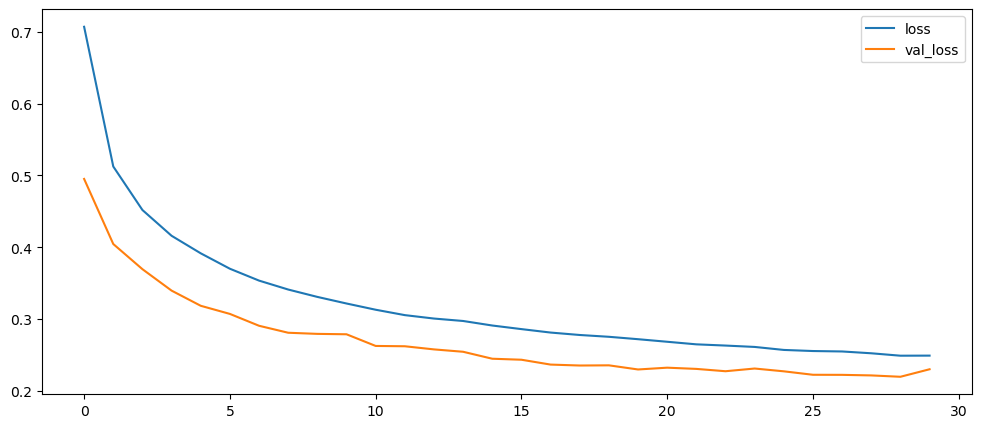

In [17]:
history_df = pd.DataFrame(hist.history)
history_df['val_f1'] = f1_metrics.val_f1s
history_df['val_precision'] = f1_metrics.val_precisions
history_df['val_recall'] = f1_metrics.val_recalls

history_df[['loss', 'val_loss']].plot()
history_df[['acc', 'val_acc']].plot()
history_df[['val_f1', 'val_precision', 'val_recall']].plot()

## 5. Submission

In [18]:
y_test = model.predict(x_test)

submission_df = pd.read_csv('../input/iwildcam-2019-fgvc6/sample_submission.csv')
submission_df['Predicted'] = y_test.argmax(axis=1)
print(submission_df.shape)
submission_df.head()

4805/4805 [==============================] - 10s 2ms/step
(153730, 4)


,Unnamed: 0,Id,Category,Predicted
0,0,b005e5b2-2c0b-11e9-bcad-06f10d5896c4,0,0
1,1,f2347cfe-2c11-11e9-bcad-06f10d5896c4,0,1
2,2,27cf8d26-2c0e-11e9-bcad-06f10d5896c4,0,0
3,3,f82f52c7-2c1d-11e9-bcad-06f10d5896c4,0,0
4,4,e133f50d-2c1c-11e9-bcad-06f10d5896c4,0,0


In [19]:
submission_df.to_csv('submission.csv',index=False)
history_df.to_csv('history.csv', index=False)

with open('history.json', 'w') as f:
    json.dump(hist.history, f)